## 05-01 코사인 유사도(Cosine Similarity)

BoW에 기반한 단어 표현 방법인 DTM, TF-IDF, 또는 뒤에서 배우게 될 Word2Vec 등과 같이 단어를 수치화할 수 있는 방법을 이해했다면 이러한 표현 방법에 대해서 코사인 유사도를 이용하여 문서의 유사도를 구하는 게 가능합니다.

### 코사인 유사도(Cosine Similarity)

코사인 유사도는 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도를 의미합니다. 코사인 유사도는 -1 이상 1 이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단할 수 있습니다. 이를 직관적으로 이해하면 두 벡터가 가리키는 방향이 얼마나 유사한가를 의미합니다.  코사인 유사도는 유사도를 구할 때 벡터의 방향(패턴)에 초점을 두므로 코사인 유사도는 문서의 길이가 다른 상황에서 비교적 공정한 비교를 할 수 있도록 도와줍니다.

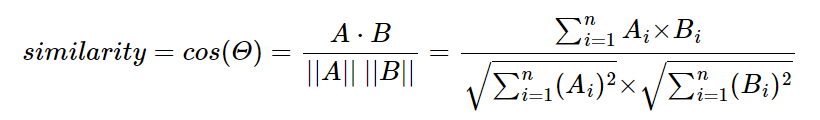

문서 단어 행렬이나 TF-IDF 행렬을 통해서 문서의 유사도를 구하는 경우에는 문서 단어 행렬이나 TF-IDF 행렬이 각각의 특징 벡터 A, B가 됩니다. 

In [31]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

doc1 = np.array([0,1,1,1])
doc2 = np.array([1,0,1,1])
doc3 = np.array([2,0,2,2])

print('문서 1과 문서2의 유사도 :',cos_sim(doc1, doc2))
print('문서 1과 문서3의 유사도 :',cos_sim(doc1, doc3))
print('문서 2와 문서3의 유사도 :',cos_sim(doc2, doc3))

문서 1과 문서2의 유사도 : 0.6666666666666667
문서 1과 문서3의 유사도 : 0.6666666666666667
문서 2와 문서3의 유사도 : 1.0000000000000002


### 유사도를 이용한 추천 시스템 구현하기

In [32]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

data = pd.read_csv('movies_metadata.csv', low_memory=False)
data.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [33]:
# 상위 2만개의 샘플을 data에 저장
data = data.head(20000)

In [34]:
# overview 열에 존재하는 모든 결측값을 전부 카운트하여 출력
print('overview 열의 결측값의 수:',data['overview'].isnull().sum())

overview 열의 결측값의 수: 135


In [35]:
# 결측값을 빈 값으로 대체
data['overview'] = data['overview'].fillna('')

In [36]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['overview'])
print('TF-IDF 행렬의 크기(shape) :',tfidf_matrix.shape)

TF-IDF 행렬의 크기(shape) : (20000, 47487)


다시 말해 20,000개의 영화를 표현하기 위해서 총 47,487개의 단어가 사용되었음을 의미합니다.  
또는 47,847차원의 문서 벡터가 20,000개가 존재한다고도 표현할 수 있을 겁니다.  
이제 20,000개의 문서 벡터에 대해서 상호 간의 코사인 유사도를 구합니다.

In [42]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print('코사인 유사도 연산 결과 :',cosine_sim.shape)

코사인 유사도 연산 결과 : (20000, 20000)


In [38]:
title_to_index = dict(zip(data['title'], data.index))

# 영화 제목 Father of the Bride Part II의 인덱스를 리턴
idx = title_to_index['Father of the Bride Part II']
print(idx)

4


In [47]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # 선택한 영화의 타이틀로부터 해당 영화의 인덱스를 받아온다.
    idx = title_to_index[title]

    # 해당 영화와 모든 영화와의 유사도를 가져온다.
    sim_scores = list(enumerate(cosine_sim[idx]))

    # 유사도에 따라 영화들을 정렬한다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 가장 유사한 10개의 영화를 받아온다.
    sim_scores = sim_scores[1:11]

    # 가장 유사한 10개의 영화의 인덱스를 얻는다.
    movie_indices = [idx[0] for idx in sim_scores]

    # 가장 유사한 10개의 영화의 제목을 리턴한다.
    return data['title'].iloc[movie_indices]

In [48]:
get_recommendations('The Dark Knight Rises')

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object